In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, f1_score
import random

# Paths to CSV file and images folder
csv_file = '/content/drive/MyDrive/Soft_Tissue/Final - Facial Profile Types.csv'
image_folder = '/content/drive/MyDrive/Soft_Tissue/cepha400'

# Load CSV
df = pd.read_csv(csv_file)

# Remove "Concave - Convex" class
df = df[df['type'] != 'Concave - Convex']

# Function to get zero-padded image filenames
def get_image_path(image_id, folder):
    image_filename = f"{str(image_id).zfill(3)}.jpg"
    return os.path.join(folder, image_filename), image_filename  # Return path and filename

# Prepare dataset: (Image, Tabular Features, Label, Image Name)
combined_data = []
for index, row in df.iterrows():
    image_id = row['data']
    label = row['type']
    upper_lip = row['upper_lip']
    lower_lip = row['lower_lip']

    image_path, image_filename = get_image_path(image_id, image_folder)
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        combined_data.append((img_array, [upper_lip, lower_lip], label, image_filename))
    except FileNotFoundError:
        print(f"Image {image_path} not found.")
        continue
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -y_true * K.log(y_pred)
        weight = alpha * K.pow((1 - y_pred), gamma)
        return K.sum(weight * ce, axis=-1)
    return loss

# Convert tabular features to One-Hot Encoding
tabular_features = np.array([sample[1] for sample in combined_data])
encoder = OneHotEncoder(sparse_output=False)
tabular_features_encoded = encoder.fit_transform(tabular_features)

# Encode the labels
labels = [sample[2] for sample in combined_data]
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

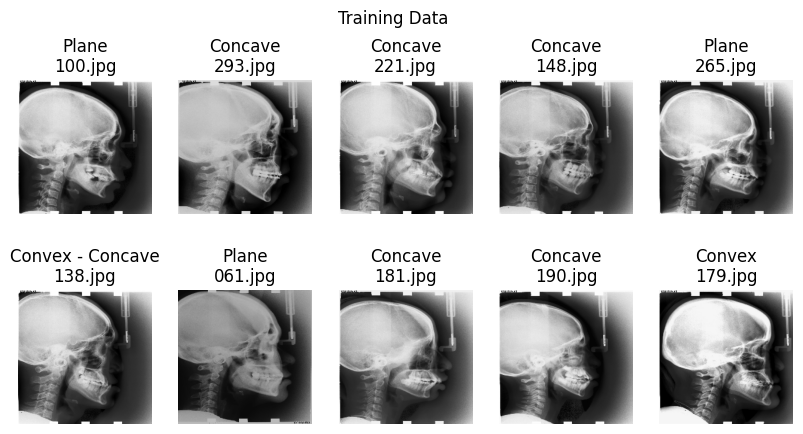

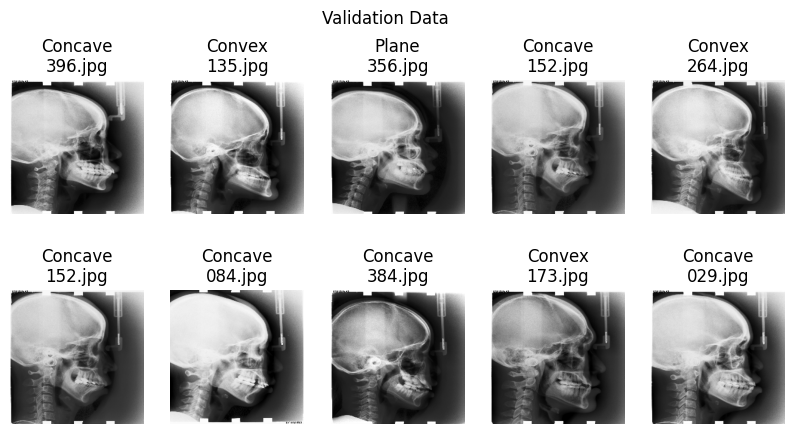

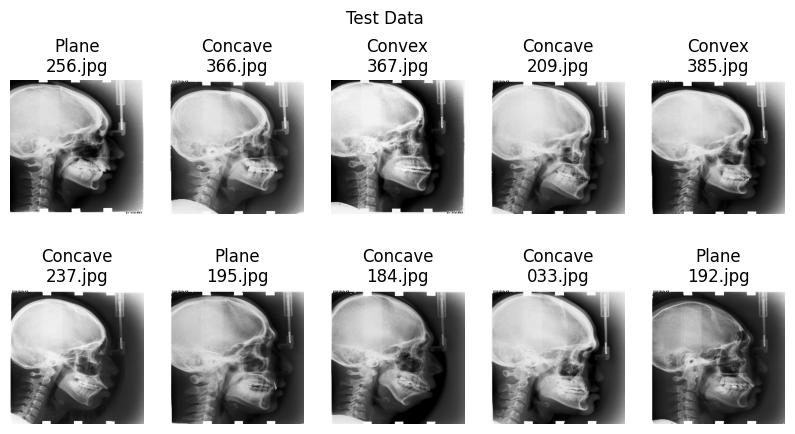

In [2]:
# Extract images and image names
images = np.array([sample[0] for sample in combined_data])
image_filenames = np.array([sample[3] for sample in combined_data])

# Create tuples with all mapped features
data_tuples = list(zip(images, tabular_features_encoded, labels_one_hot, image_filenames))

# Split dataset into Train (70%), Validation (15%), Test (15%)
train_data, temp_data = train_test_split(data_tuples, test_size=0.3, stratify=labels_encoded, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[np.argmax(sample[2]) for sample in temp_data], random_state=42)

# Visualization of images and labels after splitting
def visualize_data(data, title):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = random.randint(0, len(data) - 1)
        img, _, label, img_name = data[idx]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{label_encoder.inverse_transform([np.argmax(label)])[0]}\n{img_name}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_data(train_data, "Training Data")
visualize_data(val_data, "Validation Data")
visualize_data(test_data, "Test Data")

In [3]:
# Unpack Train, Validation, Test sets correctly
X_train_img = np.array([sample[0] for sample in train_data])
X_train_tabular = np.array([sample[1] for sample in train_data])
y_train = np.array([sample[2] for sample in train_data])

X_val_img = np.array([sample[0] for sample in val_data])
X_val_tabular = np.array([sample[1] for sample in val_data])
y_val = np.array([sample[2] for sample in val_data])

X_test_img = np.array([sample[0] for sample in test_data])
X_test_tabular = np.array([sample[1] for sample in test_data])
y_test = np.array([sample[2] for sample in test_data])


In [4]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images, augmented_tabular, augmented_labels = [], [], []

for i in range(len(X_train_img)):
    img = X_train_img[i].reshape((1,) + X_train_img[i].shape)
    tabular_features = X_train_tabular[i]
    label = y_train[i]

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(5):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_tabular.append(tabular_features)
        augmented_labels.append(label)

X_train_img = np.vstack([X_train_img, np.array(augmented_images)])
y_train = np.vstack([y_train, np.array(augmented_labels)])
X_train_tabular = np.vstack([X_train_tabular, np.array(augmented_tabular)])


In [5]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import BatchNormalization
import cv2
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the EfficientNetB7 model (excluding top layers)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Identify the last convolutional layer dynamically
last_conv_layer_name = [layer.name for layer in base_model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

# Image feature extraction
image_input = Input(shape=(224, 224, 3))
x = base_model(image_input, training=False)
x = Flatten()(x)
x = Dense(512, activation='swish')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='swish')(x)
x = BatchNormalization()(x)

# Tabular feature input
tabular_input = Input(shape=(X_train_tabular.shape[1],))
yt = Dense(64, activation='swish')(tabular_input)
yt = Dense(32, activation='swish')(yt)
yt = BatchNormalization()(yt)

# Concatenate image and tabular features
combined = Concatenate()([x, yt])
z = Dense(128, activation='swish')(combined)
z = Dropout(0.5)(z)
z = Dense(y_train.shape[1], activation='softmax')(z)

# Define model
model = Model(inputs=[image_input, tabular_input], outputs=z)

# Compile model with Categorical Focal Loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)



258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [9]:
# Train the model
history = model.fit(
    [X_train_img, X_train_tabular], y_train,
    validation_data=([X_val_img, X_val_tabular], y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.9833 - loss: 0.0036 - val_accuracy: 0.9833 - val_loss: 0.0149
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.9884 - loss: 0.0026 - val_accuracy: 0.9833 - val_loss: 0.0155
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.9910 - loss: 0.0027 - val_accuracy: 0.9833 - val_loss: 0.0155
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.9912 - loss: 0.0030 - val_accuracy: 0.9833 - val_loss: 0.0157
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.9937 - loss: 0.0020 - val_accuracy: 0.9833 - val_loss: 0.0162
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.9854 - loss: 0.0030 - val_accuracy: 0.9833 - val_loss: 0.0165
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.9923 - loss: 0.0015 - val_accuracy: 0.9833 - val_loss: 0.0166
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9878 - loss: 0.0026 - val_accu

In [10]:
# Print validation accuracy and loss
print("Validation Accuracy:", max(history.history['val_accuracy']))
print("Validation Loss:", min(history.history['val_loss']))

# Evaluate on test set
y_pred = model.predict([X_test_img, X_test_tabular])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print performance metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
print(f"Test Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Test F1 Score: {f1_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")


Validation Accuracy: 0.9833333492279053
Validation Loss: 0.014921688474714756
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
Classification Report:
                  precision    recall  f1-score   support

         Concave       1.00      1.00      1.00        37
          Convex       1.00      0.91      0.95        11
Convex - Concave       1.00      1.00      1.00         3
           Plane       0.90      1.00      0.95         9

        accuracy                           0.98        60
       macro avg       0.97      0.98      0.97        60
    weighted avg       0.98      0.98      0.98        60

Test Accuracy: 0.9833
Test F1 Score: 0.9834


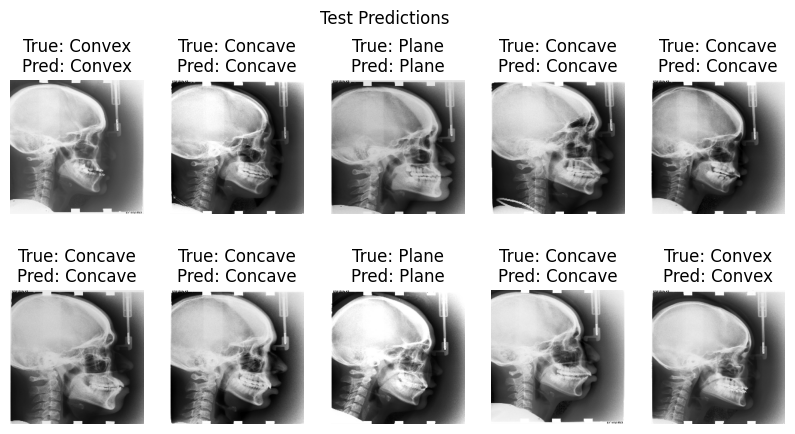

In [11]:
# Plot test results
def plot_test_results():
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = random.randint(0, len(X_test_img) - 1)
        img = X_test_img[idx]
        true_label = label_encoder.inverse_transform([y_true_classes[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred_classes[idx]])[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.suptitle("Test Predictions")
    plt.show()

plot_test_results()

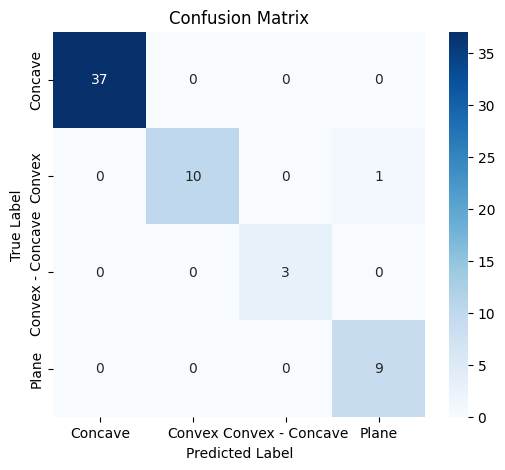

In [12]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

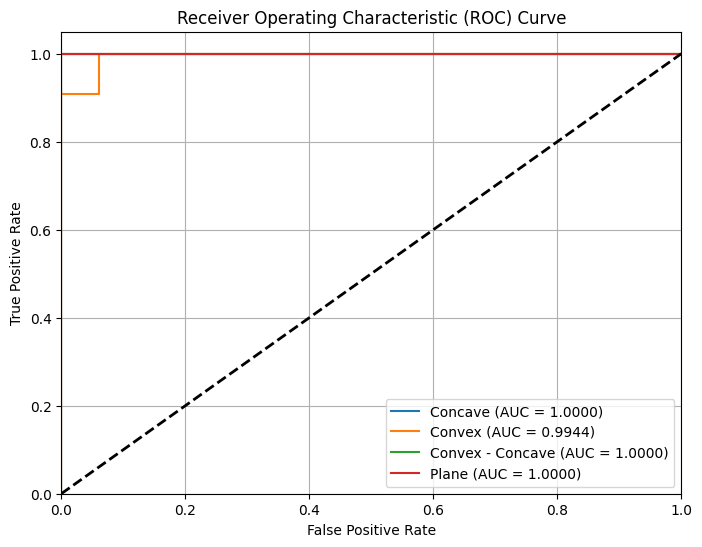

In [13]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
